In [1556]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [1557]:
# Consts etc.
data_path = "data/"

# Experiment 1

In [1558]:
# Load data

e1_file_names = ["experiment 1 run 1.txt", "experiment 1 run 2.txt", "experiment 1 run 3.txt"]
e1_data = []
e1_init_cutoffs = [770, 3, 1]  # From 'data_sanity_check.ipynb'

for i, file_name in enumerate(e1_file_names):
    file_path = data_path + file_name
    db_temp = pd.read_csv(file_path, sep="\t", decimal=",", header=None)

    e1_column_names = db_temp.iloc[0]
    e1_units = db_temp.iloc[1]

    db_temp = db_temp[2:]
    db_temp.columns = e1_column_names

    db_temp = db_temp.apply(lambda col: col.str.replace(",", ".").astype(float) if col.dtype == "object" else col)
    db_temp = db_temp.iloc[e1_init_cutoffs[i]:]
    e1_data.append(db_temp)

# Make sure the data has uniform number of points
min_mes_count = min([len(e1_data[i]["Tijd"]) for i in range(len(e1_data))])
for i in range(len(e1_data)):
    e1_data[i] = e1_data[i].iloc[:min_mes_count]

# Test
print(e1_data[0].head())
print(len(e1_data[0]["Tijd"]))
print(len(e1_data[1]["Tijd"]))
print(len(e1_data[2]["Tijd"]))

0       Tijd     Ch1     Ch2
772  769.096  1029.0  1016.0
773  770.096   988.0   963.0
774  771.097   953.0   930.0
775  772.096   922.0   900.0
776  773.096   893.0   871.0
284
284
284


In [1559]:
# Calculate the mean and average in the mean of the three runs
def mean_and_std(data):
    return np.mean(data), np.std(data)

def mean_and_std_of_runs(data_list):
    mean_data = []
    std_data = []
    for i in range(len(data_list[0])):
        data = [data_list[j][i] for j in range(len(data_list))]
        mean, std = mean_and_std(data)
        mean_data.append(mean)
        std_data.append(std)
    return np.array(mean_data), np.array(std_data)

In [1560]:
mean_data, std_data = mean_and_std_of_runs([df["Ch1"].values for df in e1_data])

# New pandas dataframe to store the processed data
results_df = pd.DataFrame({
    "Tijd": e1_data[0]["Tijd"].values,
    "Mean_Ch1": mean_data,
    "Std_Ch1": std_data
})

# Test
print(results_df.head())

mean_data2, std_data2 = mean_and_std_of_runs([df["Ch2"].values for df in e1_data])

# New pandas dataframe to store the processed data
results_df2 = pd.DataFrame({
    "Tijd": e1_data[0]["Tijd"].values,
    "Mean_Ch2": mean_data,
    "Std_Ch2": std_data
})

# Test
print(results_df2.head())

      Tijd     Mean_Ch1    Std_Ch1
0  769.096  1018.666667   7.845735
1  770.096   972.000000  16.673332
2  771.097   938.333333  15.434449
3  772.096   907.666667  14.974052
4  773.096   879.000000  14.514361
      Tijd     Mean_Ch2    Std_Ch2
0  769.096  1018.666667   7.845735
1  770.096   972.000000  16.673332
2  771.097   938.333333  15.434449
3  772.096   907.666667  14.974052
4  773.096   879.000000  14.514361


[]

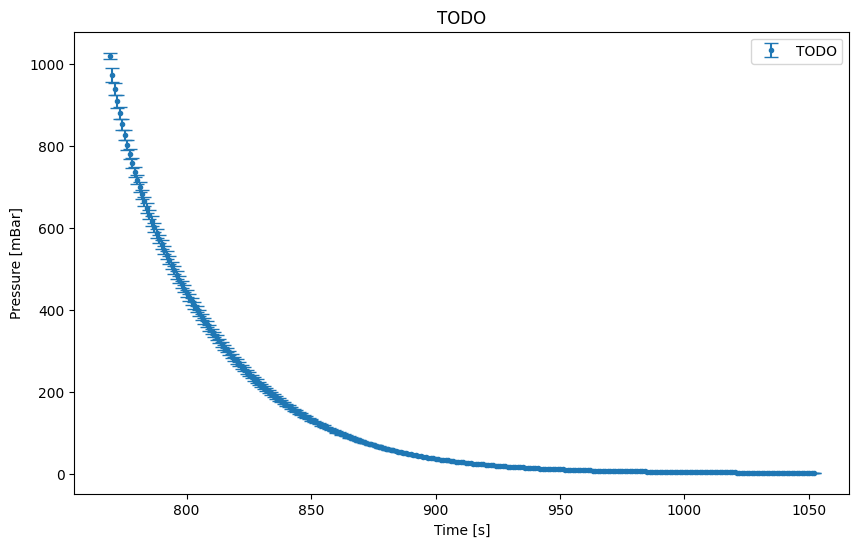

In [1561]:
plt.figure(figsize=(10, 6))
plt.errorbar(results_df["Tijd"], results_df["Mean_Ch1"], yerr=results_df["Std_Ch1"], fmt='.', label='TODO', capsize=5)

plt.title("TODO")
plt.xlabel("Time [s]")
plt.ylabel("Pressure [mBar]")

plt.legend()
plt.plot()

p0 = 1018.6667 +/- 7.8457
Fitted parameters: a = -2.504602e-02 +/- 1.868726e-04, b = 19.2140 +/- 0.1472


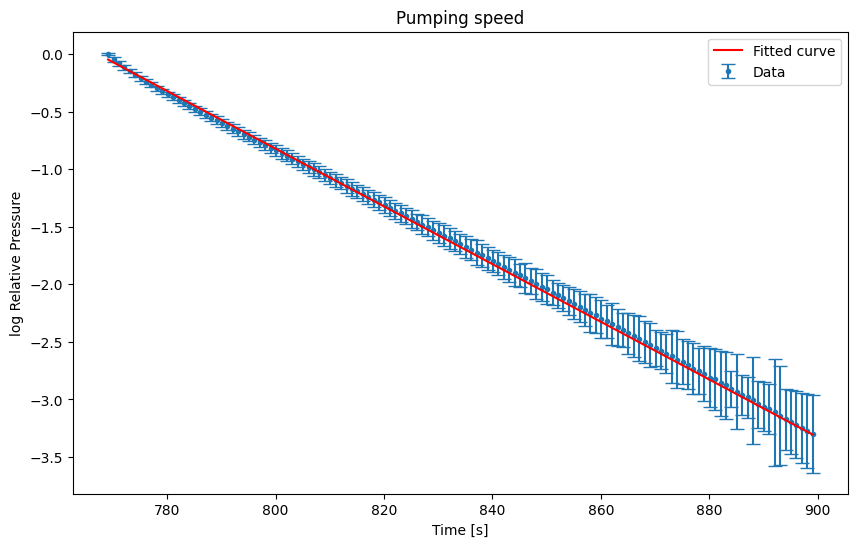

In [1562]:
# p0 = (results_df["Mean_Ch1"].iloc[0] + results_df["Std_Ch1"].iloc[0]) / 2
# p0_err = p0 * np.sqrt((results_df["Std_Ch1"].iloc[0] / results_df["Mean_Ch1"].iloc[0])**2 + (results_df["Std_Ch1"].iloc[0] / results_df["Mean_Ch1"].iloc[0])**2)
p0 = results_df["Mean_Ch1"].iloc[0]
p0_err = results_df["Std_Ch1"].iloc[0]
print(f"p0 = {p0:.4f} +/- {p0_err:.4f}")

def fit_func(x, a, b):
    return a*x + b

# The "good" zone appears to be <900s
y_data = np.log(results_df["Mean_Ch1"][results_df["Tijd"]<900].values/p0)
y_data_err = np.sqrt((p0/results_df["Mean_Ch1"][results_df["Tijd"]<900].values**2 * results_df["Std_Ch1"][results_df["Tijd"]<900].values)**2 + (p0_err/p0)**2)
x_data = results_df["Tijd"][results_df["Tijd"]<900].values

popt, pcov = curve_fit(fit_func, x_data, y_data, sigma=y_data_err, absolute_sigma=True)
a, b = popt
aerr, berr = np.sqrt(np.diag(pcov))
print(f"Fitted parameters: a = {a:.6e} +/- {aerr:.6e}, b = {b:.4f} +/- {berr:.4f}")

# Plot the fitted curve
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = fit_func(x_fit, a, b)
plt.figure(figsize=(10, 6))
plt.errorbar(x_data, y_data, yerr=y_data_err, fmt='.', label='Data', capsize=5, zorder=2)
plt.plot(x_fit, y_fit, 'r-', label='Fitted curve', zorder=3)
plt.title("Pumping speed")
plt.xlabel("Time [s]")
plt.ylabel("log Relative Pressure")
plt.legend()
plt.show()



In [1563]:
V = 50  # [l]
S = -a * V / 1000  # [m^3/s]
Serr = S * np.abs(aerr/a)

# # Manufacturer's value
# S = 5.7/3600  # [m^3/s]
# Serr = 0

# Experiment 2

In [1564]:
# Load data 2mm

e2_file_names = ["experiment 2 2mm run 1.txt", "experiment 2 2mm run 2.txt", "experiment 2 2mm run 3.txt"]
e2_data_2 = []

for i, file_name in enumerate(e2_file_names):
    file_path = data_path + file_name
    db_temp = pd.read_csv(file_path, sep="\t", decimal=",", header=None)

    e2_column_names = db_temp.iloc[0]
    e2_units = db_temp.iloc[1]

    db_temp = db_temp[2:]
    db_temp.columns = e2_column_names

    db_temp = db_temp.apply(lambda col: col.str.replace(",", ".").astype(float) if col.dtype == "object" else col)
    e2_data_2.append(db_temp)

# Make sure the data has uniform number of points
min_mes_count = min([len(e2_data_2[i]["Tijd"]) for i in range(len(e2_data_2))])
for i in range(len(e2_data_2)):
    e2_data_2[i] = e2_data_2[i].iloc[:min_mes_count]

# Test
print(e2_data_2[0].head())
print(len(e2_data_2[0]["Tijd"]))
print(len(e2_data_2[1]["Tijd"]))
print(len(e2_data_2[2]["Tijd"]))

######################################## Get the actual pandas dataframes

mean_data_c1_2mm, std_data_c1_2mm = mean_and_std_of_runs([df["Ch1"].values for df in e2_data_2])

# New pandas dataframe to store the processed data
results_df_c1_2mm = pd.DataFrame({
    "Tijd": e2_data_2[0]["Tijd"].values,
    "Mean_Ch1": mean_data_c1_2mm,
    "Std_Ch1": std_data_c1_2mm
})

# Test
print(results_df.head())

mean_data_c2_2mm, std_data_c2_2mm = mean_and_std_of_runs([df["Ch2"].values for df in e2_data_2])

# New pandas dataframe to store the processed data
results_df_c2_2mm = pd.DataFrame({
    "Tijd": e2_data_2[0]["Tijd"].values,
    "Mean_Ch2": mean_data_c2_2mm,
    "Std_Ch2": std_data_c2_2mm
})

# Test
print(results_df2.head())

0   Tijd    Ch1     Ch2
2  4.363  386.0  1007.0
3  5.363  313.0  1000.0
4  6.363  269.0   993.0
5  7.363  240.0   986.0
6  8.363  222.0   980.0
1330
1330
1330
      Tijd     Mean_Ch1    Std_Ch1
0  769.096  1018.666667   7.845735
1  770.096   972.000000  16.673332
2  771.097   938.333333  15.434449
3  772.096   907.666667  14.974052
4  773.096   879.000000  14.514361
      Tijd     Mean_Ch2    Std_Ch2
0  769.096  1018.666667   7.845735
1  770.096   972.000000  16.673332
2  771.097   938.333333  15.434449
3  772.096   907.666667  14.974052
4  773.096   879.000000  14.514361


In [1565]:
# Load data 3mm

e2_file_names = ["experiment 2 3mm run 1.txt", "experiment 2 3mm run 2.txt", "experiment 2 3mm run 3.txt"]
e2_data_3 = []

for i, file_name in enumerate(e2_file_names):
    file_path = data_path + file_name
    db_temp = pd.read_csv(file_path, sep="\t", decimal=",", header=None)

    e2_column_names = db_temp.iloc[0]
    e2_units = db_temp.iloc[1]

    db_temp = db_temp[2:]
    db_temp.columns = e2_column_names

    db_temp = db_temp.apply(lambda col: col.str.replace(",", ".").astype(float) if col.dtype == "object" else col)
    e2_data_3.append(db_temp)

# Make sure the data has uniform number of points
min_mes_count = min([len(e2_data_3[i]["Tijd"]) for i in range(len(e2_data_3))])
for i in range(len(e2_data_3)):
    e2_data_3[i] = e2_data_3[i].iloc[:min_mes_count]

# Test
print(e2_data_3[0].head())
print(len(e2_data_3[0]["Tijd"]))
print(len(e2_data_3[1]["Tijd"]))
print(len(e2_data_3[2]["Tijd"]))

######################################## Get the actual pandas dataframes

mean_data_c1_3mm, std_data_c1_3mm = mean_and_std_of_runs([df["Ch1"].values for df in e2_data_3])

# New pandas dataframe to store the processed data
results_df_c1_3mm = pd.DataFrame({
    "Tijd": e2_data_3[0]["Tijd"].values,
    "Mean_Ch1": mean_data_c1_3mm,
    "Std_Ch1": std_data_c1_3mm
})

# Test
print(results_df.head())

mean_data_c2_3mm, std_data_c2_3mm = mean_and_std_of_runs([df["Ch2"].values for df in e2_data_3])

# New pandas dataframe to store the processed data
results_df_c2_3mm = pd.DataFrame({
    "Tijd": e2_data_3[0]["Tijd"].values,
    "Mean_Ch2": mean_data_c2_3mm,
    "Std_Ch2": std_data_c2_3mm
})

# Test
print(results_df2.head())

0   Tijd    Ch1     Ch2
2  4.931  541.0  1009.0
3  5.930  521.0   991.0
4  6.930  508.0   974.0
5  7.931  496.0   957.0
6  8.930  487.0   941.0
400
400
400
      Tijd     Mean_Ch1    Std_Ch1
0  769.096  1018.666667   7.845735
1  770.096   972.000000  16.673332
2  771.097   938.333333  15.434449
3  772.096   907.666667  14.974052
4  773.096   879.000000  14.514361
      Tijd     Mean_Ch2    Std_Ch2
0  769.096  1018.666667   7.845735
1  770.096   972.000000  16.673332
2  771.097   938.333333  15.434449
3  772.096   907.666667  14.974052
4  773.096   879.000000  14.514361


In [1566]:
# Load data 4mm

e2_file_names = ["experiment 2 4mm run 1.txt", "experiment 2 4mm run 2.txt", "experiment 2 4mm run 3.txt"]
e2_data_4 = []

for i, file_name in enumerate(e2_file_names):
    file_path = data_path + file_name
    db_temp = pd.read_csv(file_path, sep="\t", decimal=",", header=None)

    e2_column_names = db_temp.iloc[0]
    e2_units = db_temp.iloc[1]

    db_temp = db_temp[2:]
    db_temp.columns = e2_column_names

    db_temp = db_temp.apply(lambda col: col.str.replace(",", ".").astype(float) if col.dtype == "object" else col)
    e2_data_4.append(db_temp)

# Make sure the data has uniform number of points
min_mes_count = min([len(e2_data_4[i]["Tijd"]) for i in range(len(e2_data_4))])
for i in range(len(e2_data_4)):
    e2_data_4[i] = e2_data_4[i].iloc[:min_mes_count]

# Test
print(e2_data_4[0].head())
print(len(e2_data_4[0]["Tijd"]))
print(len(e2_data_4[1]["Tijd"]))
print(len(e2_data_4[2]["Tijd"]))

######################################## Get the actual pandas dataframes

mean_data_c1_4mm, std_data_c1_4mm = mean_and_std_of_runs([df["Ch1"].values for df in e2_data_4])

# New pandas dataframe to store the processed data
results_df_c1_4mm = pd.DataFrame({
    "Tijd": e2_data_4[0]["Tijd"].values,
    "Mean_Ch1": mean_data_c1_4mm,
    "Std_Ch1": std_data_c1_4mm
})

# Test
print(results_df.head())

mean_data_c2_4mm, std_data_c2_4mm = mean_and_std_of_runs([df["Ch2"].values for df in e2_data_4])

# New pandas dataframe to store the processed data
results_df_c2_4mm = pd.DataFrame({
    "Tijd": e2_data_4[0]["Tijd"].values,
    "Mean_Ch2": mean_data_c2_4mm,
    "Std_Ch2": std_data_c2_4mm
})

# Test
print(results_df2.head())

0   Tijd    Ch1    Ch2
2  5.731  633.0  989.0
3  6.730  680.0  963.0
4  7.731  689.0  939.0
5  8.730  684.0  916.0
6  9.731  674.0  894.0
205
205
205
      Tijd     Mean_Ch1    Std_Ch1
0  769.096  1018.666667   7.845735
1  770.096   972.000000  16.673332
2  771.097   938.333333  15.434449
3  772.096   907.666667  14.974052
4  773.096   879.000000  14.514361
      Tijd     Mean_Ch2    Std_Ch2
0  769.096  1018.666667   7.845735
1  770.096   972.000000  16.673332
2  771.097   938.333333  15.434449
3  772.096   907.666667  14.974052
4  773.096   879.000000  14.514361


In [1567]:
d2mm = 2e-3  # [m]
d3mm = 3e-3  # [m]
d4mm = 4e-3  # [m]

eta = 1.85e-5  # [kg/m/s], this is at room temp (20), assumed to be constant with pressure Reference: the lab book [6]
l = 0.575  # [m]

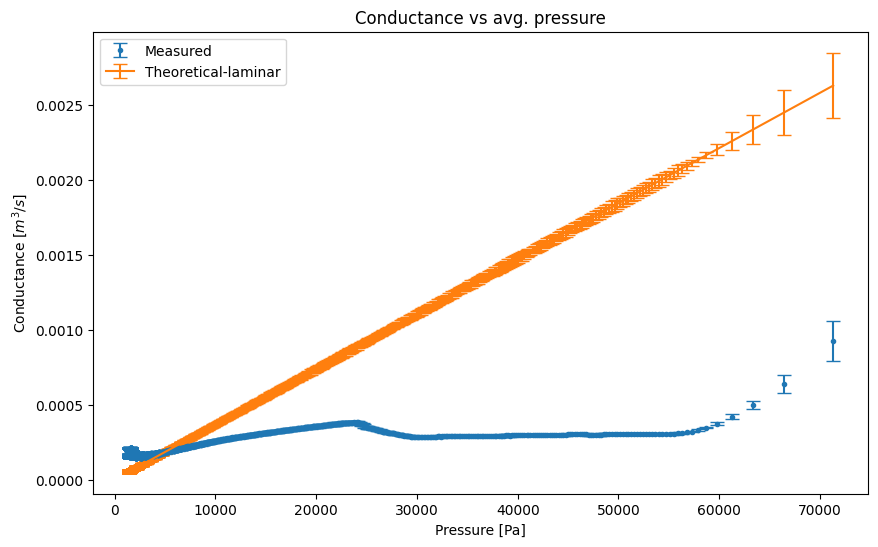

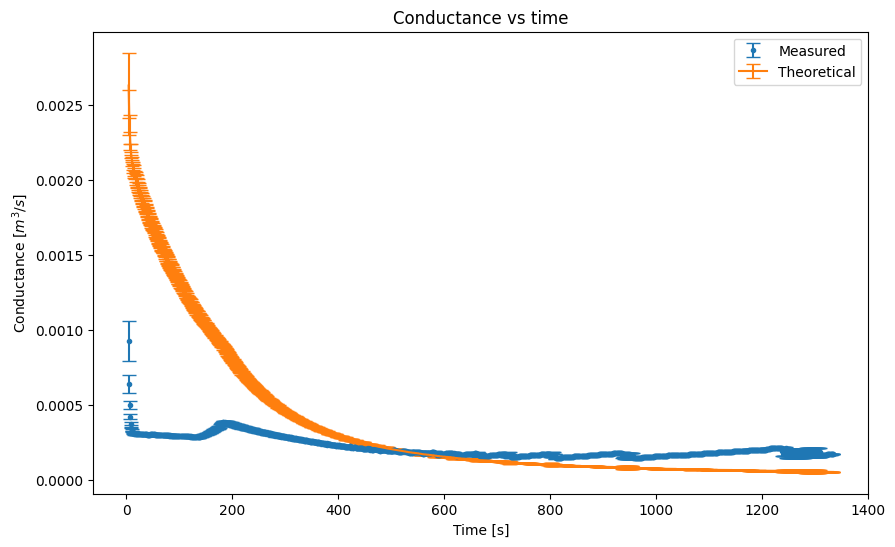

In [1568]:
# Note: graphs do not start at athmospheric pressure cause different experimental runs had to be unified (thus they start exactly at first pressure drop)

# ch1 - above (pp)
# ch2 - below (p)
Cm_2mm = S * results_df_c1_2mm["Mean_Ch1"] / (results_df_c2_2mm["Mean_Ch2"] - results_df_c1_2mm["Mean_Ch1"])
# Cm_2mm = S * results_df_c1_2mm["Mean_Ch1"] / (results_df_c2_2mm["Mean_Ch2"] - results_df_c1_2mm["Mean_Ch1"])
Cm_2mm_err = np.abs(Cm_2mm) * np.sqrt((Serr/S)**2 + (results_df_c2_2mm["Std_Ch2"]/(results_df_c2_2mm["Mean_Ch2"]-results_df_c1_2mm["Mean_Ch1"]))**2 + (results_df_c2_2mm["Mean_Ch2"]/(results_df_c1_2mm["Mean_Ch1"]*(results_df_c2_2mm["Mean_Ch2"]-results_df_c1_2mm["Mean_Ch1"]))*results_df_c1_2mm["Std_Ch1"])**2)

p_avg_2mm = (results_df_c2_2mm["Mean_Ch2"] + results_df_c1_2mm["Mean_Ch1"]) / 2 * 100
p_avg_2mm_err = np.abs(p_avg_2mm) * np.sqrt((results_df_c2_2mm["Std_Ch2"]/results_df_c2_2mm["Mean_Ch2"])**2 + (results_df_c1_2mm["Std_Ch1"]/results_df_c1_2mm["Mean_Ch1"])**2)

Ct_2mm = np.pi*d2mm**4 / (128*eta*l) * p_avg_2mm
Ct_2mm_err = np.pi*d2mm**4 / (128*eta*l) * p_avg_2mm_err

cutoff = 0  # Discard the first few points as the pressures are similar and the errors large
plt.figure(figsize=(10, 6))
plt.errorbar(p_avg_2mm[cutoff:], Cm_2mm[cutoff:], yerr=Cm_2mm_err[cutoff:], fmt='.', label='Measured', capsize=5)
plt.errorbar(p_avg_2mm[cutoff:], Ct_2mm[cutoff:], yerr=Ct_2mm_err[cutoff:], label='Theoretical-laminar', capsize=5)
plt.title("Conductance vs avg. pressure")
plt.xlabel("Pressure [Pa]")
plt.ylabel(f"Conductance [$m^3/s$]")
plt.legend()
plt.show()


# A time plot for double check
cutoff = 0  # Discard the first few points as the pressures are similar and the errors large
plt.figure(figsize=(10, 6))
plt.errorbar(results_df_c1_2mm["Tijd"][cutoff:], Cm_2mm[cutoff:], yerr=Cm_2mm_err[cutoff:], fmt='.', label='Measured', capsize=5)
plt.errorbar(results_df_c1_2mm["Tijd"][cutoff:], Ct_2mm[cutoff:], yerr=Ct_2mm_err[cutoff:], label='Theoretical', capsize=5)
plt.title("Conductance vs time")
plt.xlabel("Time [s]")
plt.ylabel(f"Conductance [$m^3/s$]")
plt.legend()
plt.show()


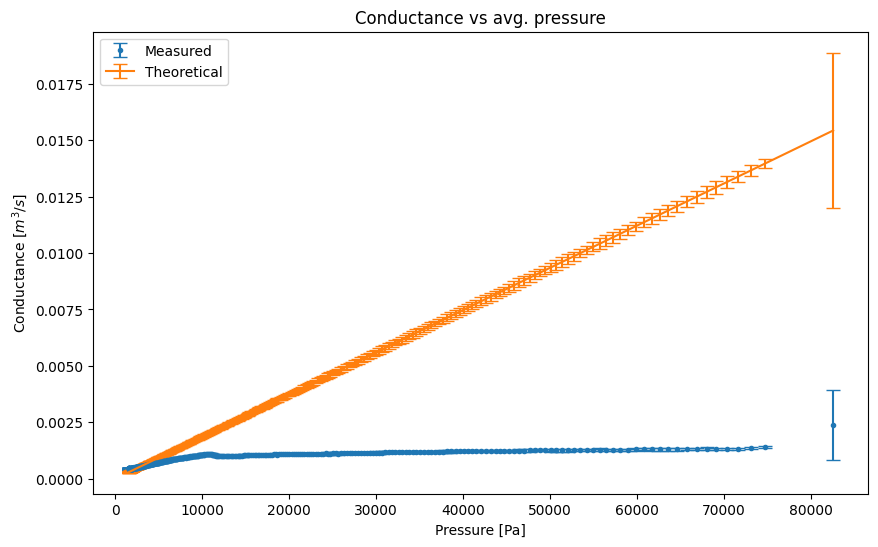

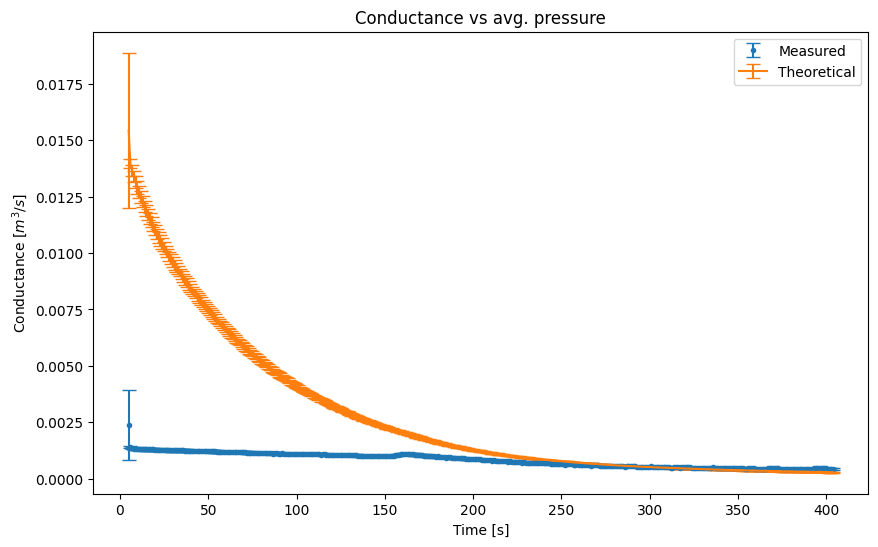

In [1569]:
# ch1 - above (pp)
# ch2 - below (p)
Cm_3mm = S * results_df_c1_3mm["Mean_Ch1"] / (results_df_c2_3mm["Mean_Ch2"] - results_df_c1_3mm["Mean_Ch1"])
Cm_3mm_err = np.abs(Cm_3mm) * np.sqrt((Serr/S)**2 + (results_df_c2_3mm["Std_Ch2"]/(results_df_c2_3mm["Mean_Ch2"]-results_df_c1_3mm["Mean_Ch1"]))**2 + (results_df_c2_3mm["Mean_Ch2"]/(results_df_c1_3mm["Mean_Ch1"]*(results_df_c2_3mm["Mean_Ch2"]-results_df_c1_3mm["Mean_Ch1"]))*results_df_c1_3mm["Std_Ch1"])**2)

p_avg_3mm = (results_df_c2_3mm["Mean_Ch2"] + results_df_c1_3mm["Mean_Ch1"]) / 2 * 100
p_avg_3mm_err = np.abs(p_avg_3mm) * np.sqrt((results_df_c2_3mm["Std_Ch2"]/results_df_c2_3mm["Mean_Ch2"])**2 + (results_df_c1_3mm["Std_Ch1"]/results_df_c1_3mm["Mean_Ch1"])**2)

Ct_3mm = np.pi*d3mm**4 / (128*eta*l) * p_avg_3mm
Ct_3mm_err = np.pi*d3mm**4 / (128*eta*l) * p_avg_3mm_err

cutoff = 0  # Discard the first few points as the pressures are similar and the errors large
plt.figure(figsize=(10, 6))
plt.errorbar(p_avg_3mm[cutoff:], Cm_3mm[cutoff:], yerr=Cm_3mm_err[cutoff:], fmt='.', label='Measured', capsize=5)
plt.errorbar(p_avg_3mm[cutoff:], Ct_3mm[cutoff:], yerr=Ct_3mm_err[cutoff:], label='Theoretical', capsize=5)
plt.title("Conductance vs avg. pressure")
plt.xlabel("Pressure [Pa]")
plt.ylabel(f"Conductance [$m^3/s$]")
# plt.xscale("log")
# plt.yscale("log")
plt.legend()
plt.show()

# A time plot for double check
cutoff = 0  # Discard the first few points as the pressures are similar and the errors large
plt.figure(figsize=(10, 6))
plt.errorbar(results_df_c1_3mm["Tijd"][cutoff:], Cm_3mm[cutoff:], yerr=Cm_3mm_err[cutoff:], fmt='.', label='Measured', capsize=5)
plt.errorbar(results_df_c1_3mm["Tijd"][cutoff:], Ct_3mm[cutoff:], yerr=Ct_3mm_err[cutoff:], label='Theoretical', capsize=5)
plt.title("Conductance vs avg. pressure")
plt.xlabel("Time [s]")
plt.ylabel(f"Conductance [$m^3/s$]")
plt.legend()
plt.show()


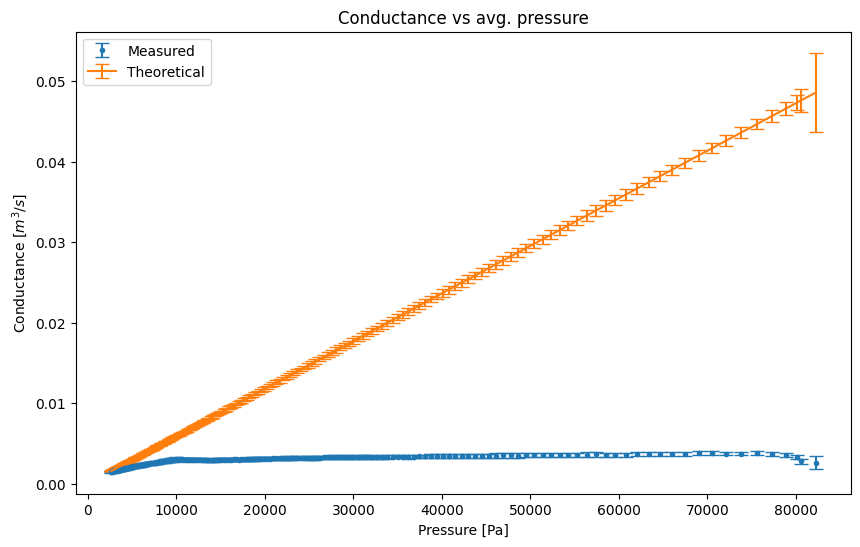

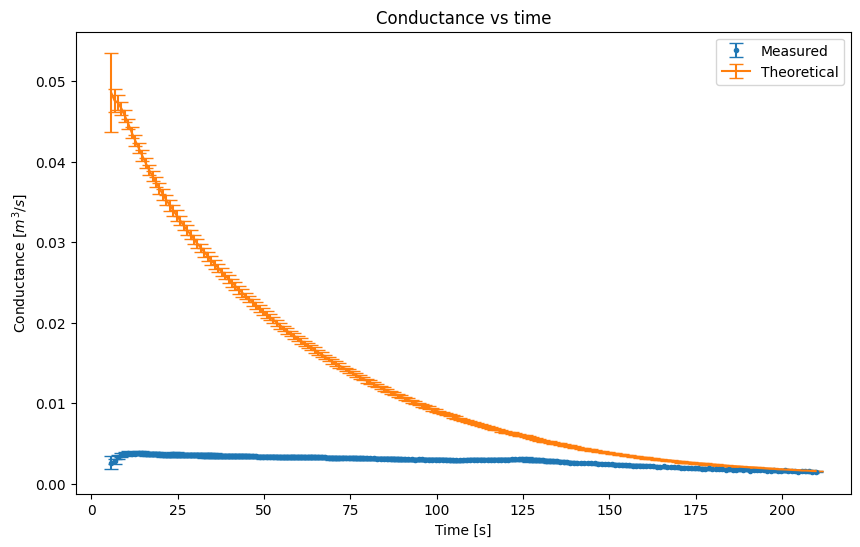

In [1570]:
# ch1 - above (pp)
# ch2 - below (p)
Cm_4mm = S * results_df_c1_4mm["Mean_Ch1"] / (results_df_c2_4mm["Mean_Ch2"] - results_df_c1_4mm["Mean_Ch1"])
# Cm_4mm = S * results_df_c1_4mm["Mean_Ch1"] / (results_df_c2_4mm["Mean_Ch2"] - results_df_c1_4mm["Mean_Ch1"])
Cm_4mm_err = np.abs(Cm_4mm) * np.sqrt((Serr/S)**2 + (results_df_c2_4mm["Std_Ch2"]/(results_df_c2_4mm["Mean_Ch2"]-results_df_c1_4mm["Mean_Ch1"]))**2 + (results_df_c2_4mm["Mean_Ch2"]/(results_df_c1_4mm["Mean_Ch1"]*(results_df_c2_4mm["Mean_Ch2"]-results_df_c1_4mm["Mean_Ch1"]))*results_df_c1_4mm["Std_Ch1"])**2)

p_avg_4mm = (results_df_c2_4mm["Mean_Ch2"] + results_df_c1_4mm["Mean_Ch1"]) / 2 * 100
p_avg_4mm_err = np.abs(p_avg_4mm) * np.sqrt((results_df_c2_4mm["Std_Ch2"]/results_df_c2_4mm["Mean_Ch2"])**2 + (results_df_c1_4mm["Std_Ch1"]/results_df_c1_4mm["Mean_Ch1"])**2)

Ct_4mm = np.pi*d4mm**4 / (128*eta*l) * p_avg_4mm
Ct_4mm_err = np.pi*d4mm**4 / (128*eta*l) * p_avg_4mm_err

cutoff = 0  # Discard the first few points as the pressures are similar and the errors large
plt.figure(figsize=(10, 6))
plt.errorbar(p_avg_4mm[cutoff:], Cm_4mm[cutoff:], yerr=Cm_4mm_err[cutoff:], fmt='.', label='Measured', capsize=5)
plt.errorbar(p_avg_4mm[cutoff:], Ct_4mm[cutoff:], yerr=Ct_4mm_err[cutoff:], label='Theoretical', capsize=5)
plt.title("Conductance vs avg. pressure")
plt.xlabel("Pressure [Pa]")
plt.ylabel(f"Conductance [$m^3/s$]")
plt.legend()
plt.show()


# A time plot for double check
cutoff = 0  # Discard the first few points as the pressures are similar and the errors large
plt.figure(figsize=(10, 6))
plt.errorbar(results_df_c1_4mm["Tijd"][cutoff:], Cm_4mm[cutoff:], yerr=Cm_4mm_err[cutoff:], fmt='.', label='Measured', capsize=5)
plt.errorbar(results_df_c1_4mm["Tijd"][cutoff:], Ct_4mm[cutoff:], yerr=Ct_4mm_err[cutoff:], label='Theoretical', capsize=5)
plt.title("Conductance vs time")
plt.xlabel("Time [s]")
plt.ylabel(f"Conductance [$m^3/s$]")
plt.legend()
plt.show()


In [1571]:
# molar mass of air
M = 28.96e-3  # [kg/mol]
T = 25.7 + 273.15  # [K]
Terr = 1  # [K]
R = 8.314  # [J/(mol*K)]
rho = 1.2  # [kg/m^3]


## From [6] criterion for laminar flow in cylindrical tubes is Re < 1000

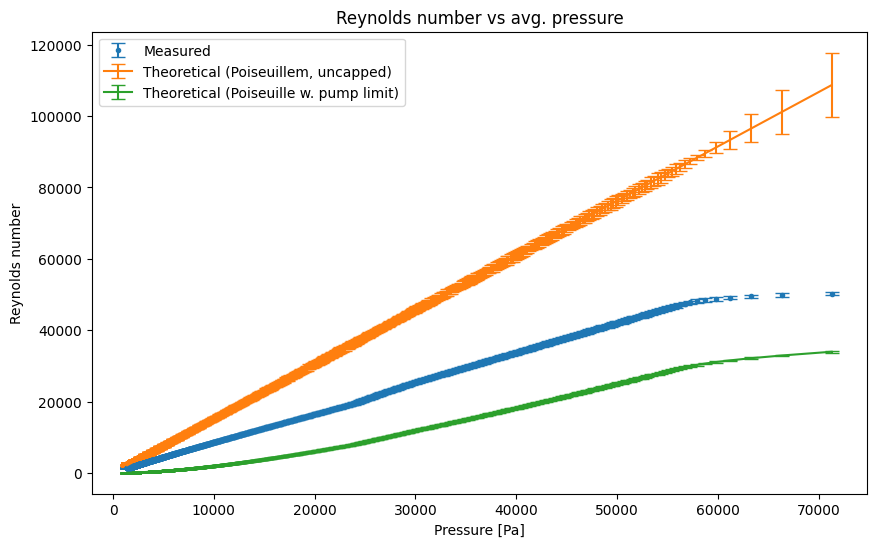

In [1572]:
Re_2mm = 4*M/(np.pi * eta * R * T) * S * results_df_c2_2mm["Mean_Ch2"]*100 / d2mm  # ch2 here cause we swapped the pressures in the prep.
Re_2mm_err = np.abs(Re_2mm) * np.sqrt((Serr/S)**2 + (results_df_c2_2mm["Std_Ch2"]/(results_df_c2_2mm["Mean_Ch2"]))**2 + (Terr/T)**2)

Re_t_2mm = rho * d2mm**3/(32 * eta**2 * l) * p_avg_2mm
Re_t_2mm_err = rho * d2mm**3/(32 * eta**2 * l) * p_avg_2mm_err

C = np.pi*d2mm**4 / (128*eta*l) * p_avg_2mm
Re_t_2mm_c = 0.8 / d2mm * C*S/(C+S) * results_df_c2_2mm["Mean_Ch2"]*100
Re_t_2mm_c_err = np.abs(Re_t_2mm_c)*np.sqrt((results_df_c2_2mm["Std_Ch2"]/results_df_c2_2mm["Mean_Ch2"])**2 + (C/(S*(C+S))*Serr)**2)

plt.figure(figsize=(10, 6))
plt.errorbar(p_avg_2mm[cutoff:], Re_2mm[cutoff:], yerr=Re_2mm_err[cutoff:], fmt='.', label='Measured', capsize=5)
plt.errorbar(p_avg_2mm[cutoff:], Re_t_2mm[cutoff:], yerr=Re_t_2mm_err[cutoff:], label='Theoretical (Poiseuillem, uncapped)', capsize=5)
plt.errorbar(p_avg_2mm[cutoff:], Re_t_2mm_c[cutoff:], yerr=Re_t_2mm_c_err[cutoff:], label='Theoretical (Poiseuille w. pump limit)', capsize=5)
plt.title("Reynolds number vs avg. pressure")
plt.xlabel("Pressure [Pa]")
plt.ylabel(f"Reynolds number")
plt.legend()
plt.show()


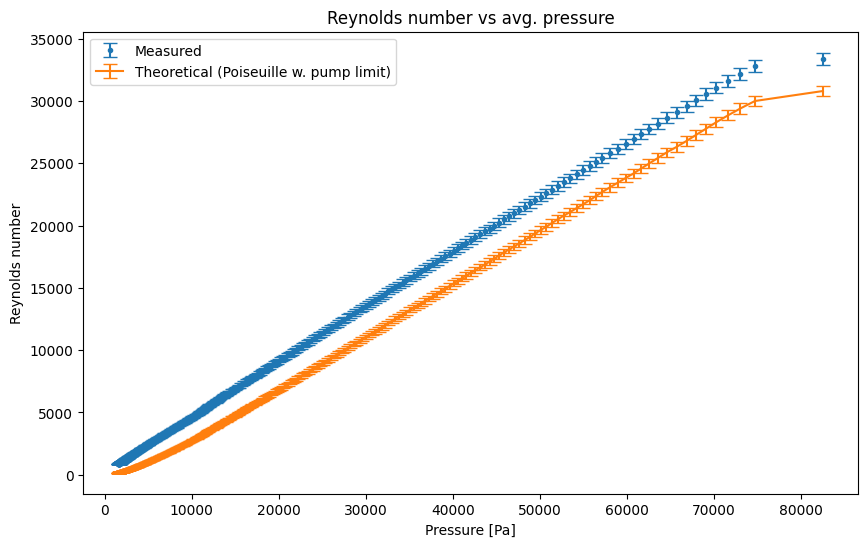

In [1573]:
Re_3mm = 4*M/(np.pi * eta * R * T) * S * results_df_c2_3mm["Mean_Ch2"]*100 / d3mm  # ch2 here cause we swapped the pressures in the prep.
Re_3mm_err = np.abs(Re_3mm) * np.sqrt((Serr/S)**2 + (results_df_c2_3mm["Std_Ch2"]/(results_df_c2_3mm["Mean_Ch2"]))**2 + (Terr/T)**2)

Re_t_3mm = rho * d3mm**3/(32 * eta**2 * l) * p_avg_3mm
Re_t_3mm_err = rho * d3mm**3/(32 * eta**2 * l) * p_avg_3mm_err

C = np.pi*d3mm**4 / (128*eta*l) * p_avg_3mm
Re_t_3mm_c = 0.8 / d3mm * C*S/(C+S) * results_df_c2_3mm["Mean_Ch2"]*100
Re_t_3mm_c_err = np.abs(Re_t_3mm_c)*np.sqrt((results_df_c2_3mm["Std_Ch2"]/results_df_c2_3mm["Mean_Ch2"])**2 + (C/(S*(C+S))*Serr)**2)

plt.figure(figsize=(10, 6))
plt.errorbar(p_avg_3mm[cutoff:], Re_3mm[cutoff:], yerr=Re_3mm_err[cutoff:], fmt='.', label='Measured', capsize=5)
# plt.errorbar(p_avg_3mm[cutoff:], Re_t_3mm[cutoff:], yerr=Re_t_3mm_err[cutoff:], label='Theoretical (Poiseuillem, uncapped)', capsize=5)
plt.errorbar(p_avg_3mm[cutoff:], Re_t_3mm_c[cutoff:], yerr=Re_t_3mm_c_err[cutoff:], label='Theoretical (Poiseuille w. pump limit)', capsize=5)
plt.title("Reynolds number vs avg. pressure")
plt.xlabel("Pressure [Pa]")
plt.ylabel(f"Reynolds number")
plt.legend()
plt.show()


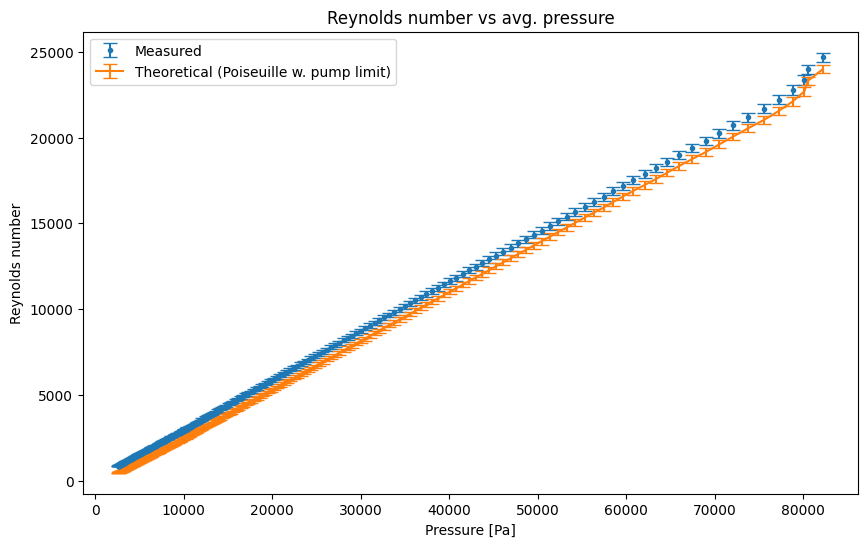

In [1574]:
Re_4mm = 4*M/(np.pi * eta * R * T) * S * results_df_c2_4mm["Mean_Ch2"]*100 / d4mm  # ch2 here cause we swapped the pressures in the prep.
Re_4mm_err = np.abs(Re_4mm) * np.sqrt((Serr/S)**2 + (results_df_c2_4mm["Std_Ch2"]/(results_df_c2_4mm["Mean_Ch2"]))**2 + (Terr/T)**2)

Re_t_4mm = rho * d4mm**3/(32 * eta**2 * l) * p_avg_4mm
Re_t_4mm_err = rho * d4mm**3/(32 * eta**2 * l) * p_avg_4mm_err

C = np.pi*d4mm**4 / (128*eta*l) * p_avg_4mm
Re_t_4mm_c = 0.8 / d4mm * C*S/(C+S) * results_df_c2_4mm["Mean_Ch2"]*100
Re_t_4mm_c_err = np.abs(Re_t_4mm_c)*np.sqrt((results_df_c2_4mm["Std_Ch2"]/results_df_c2_4mm["Mean_Ch2"])**2 + (C/(S*(C+S))*Serr)**2)

plt.figure(figsize=(10, 6))
plt.errorbar(p_avg_4mm[cutoff:], Re_4mm[cutoff:], yerr=Re_4mm_err[cutoff:], fmt='.', label='Measured', capsize=5)
# plt.errorbar(p_avg_4mm[cutoff:], Re_t_4mm[cutoff:], yerr=Re_t_4mm_err[cutoff:], label='Theoretical (Poiseuillem, uncapped)', capsize=5)
plt.errorbar(p_avg_4mm[cutoff:], Re_t_4mm_c[cutoff:], yerr=Re_t_4mm_c_err[cutoff:], label='Theoretical (Poiseuille w. pump limit)', capsize=5)
plt.title("Reynolds number vs avg. pressure")
plt.xlabel("Pressure [Pa]")
plt.ylabel(f"Reynolds number")
plt.legend()
plt.show()
